In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import os

In [2]:
def create_date_range(start='2018-08-31', end='2024-08-31', freq='M', periods=None):
    try:
        date_range = pd.date_range(
            start=start, 
            end=end, 
            freq=freq, 
            periods=periods
        )
        return date_range
    except Exception as e:
        print(f"Error creating date range: {e}")
        return None

In [3]:
# Load the data
cwd = os.getcwd()
cwd = '/'.join(cwd.split('/')[:-1])

df = pd.read_pickle(f'{cwd}/Datasets/observed_rent_index_co.pkl')
df.head()


,RegionName,observed_rent_index
0,Denver,"[1304.498990459729, 1320.389460587924, 1336.25..."
1,Colorado Springs,"[1075.8859562843352, 1082.4341742227648, 1083...."
2,Fort Collins,"[1239.4681794663654, 1254.2975748039426, 1270...."
3,Boulder,"[1469.5117878857184, 1485.7845579329396, 1487...."
4,Greeley,"[889.9139579214843, 889.2279974686633, 1177.79..."


In [4]:
# Parameters
region = 'Boulder'
attribute = 'observed_rent_index'

# Prepare the data
values = df[df['RegionName'] == region]  # Select region
values = values[attribute]  # Select column
values = values.to_numpy()[0]  # Convert to numpy array

# Create date range
date_range = create_date_range(start='2015-01-31', end='2024-09-30', freq='M')
data = pd.DataFrame({'date': date_range, 'value': values})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(data['date']).drop('date', axis=1)
data = data.resample("MS").last()
data.head()

/var/folders/y_/b1tvl6l53p3_kgr4vjlhss9w0000gn/T/ipykernel_3862/3448905241.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


,value
date,
2015-01-01,1469.511788
2015-02-01,1485.784558
2015-03-01,1487.702406
2015-04-01,1502.395506
2015-05-01,1506.690133


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-633.169, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-609.026, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-642.793, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-637.344, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-554.381, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-631.116, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-657.116, Time=0.70 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-643.733, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-649.875, Time=0.23 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-621.540, Time=0.70 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-657.723, Time=1.00 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-647.797, Time=0.22 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=-647.796, Time=1.40 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-652.480, Time=0.50 sec
 ARIMA(3,1,0)(2,0,0

/usr/local/Caskroom/miniconda/base/envs/data_mining/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 145.3590988942533
MAE: 134.54038121028415
MAPE: 5.85%


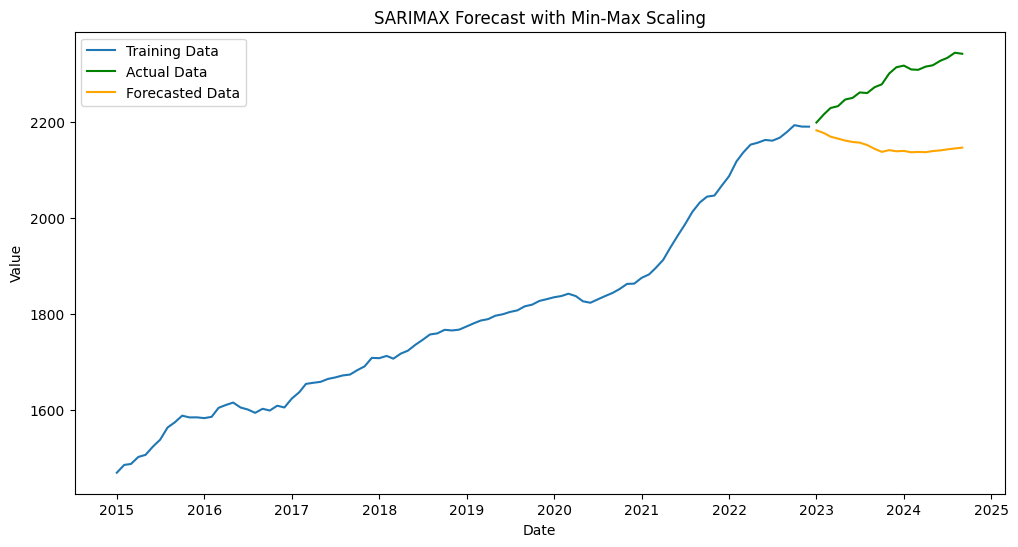

In [5]:
# Scale the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data[['value']])
data['scaled_value'] = scaled_values

# Train-test split
train = data[data.index.year < 2023]['scaled_value']
test = data[data.index.year >= 2023]['scaled_value']

# Use auto_arima to determine the seasonal order (P, D, Q, s)
stepwise_model = auto_arima(train, 
                            start_p=1, start_q=1,
                            max_p=3, max_q=3, d=1,
                            start_P=0, start_Q=0,
                            max_P=2, max_Q=2, 
                            seasonal=True, 
                            m=12,  # Monthly seasonality
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Display the chosen SARIMAX order
print(f"Optimal SARIMA order: {stepwise_model.order}")
print(f"Optimal Seasonal order: {stepwise_model.seasonal_order}")

# Fit the SARIMAX model
model = SARIMAX(train, 
                order=stepwise_model.order, 
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
fitted_model = model.fit(disp=False)

# Forecast
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

# Reverse scaling of forecast and test data
forecast_original = scaler.inverse_transform(forecast.values.reshape(-1, 1)).flatten()
test_original = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()

# Evaluation metrics on original scale
rmse = np.sqrt(mean_squared_error(test_original, forecast_original))
mae = mean_absolute_error(test_original, forecast_original)
mape = np.mean(np.abs((test_original - forecast_original) / test_original)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data[data.index.year < 2023].index, scaler.inverse_transform(train.values.reshape(-1, 1)), label="Training Data")
plt.plot(data[data.index.year >= 2023].index, test_original, label="Actual Data", color='green')
plt.plot(data[data.index.year >= 2023].index, forecast_original, label="Forecasted Data", color='orange')
plt.title("SARIMAX Forecast with Min-Max Scaling")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()
